<a href="https://colab.research.google.com/github/bhanukad610/MTDAP-Traffic-volume-forecasting/blob/main/Rolling_Forecast_Origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from datetime import timedelta
from statistics import mean 
from prettytable import PrettyTable

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/FYP/df_vector_weather_one_hr_cleaned.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [ ]:
df = df['2017-06-01 00:00:00':'2019-08-21 00:00:00']
df['rain_1h'].replace([np.nan], value = [0], inplace = True)
df['rain_3h'].replace([np.nan], value = [0], inplace = True)
df['snow_1h'].replace([np.nan], value = [0], inplace = True)
df['snow_3h'].replace([np.nan], value = [0], inplace = True)
df['traffic_volume'] = df['traffic_volume'].interpolate(method ='time')
df['speed_avg'] = df['speed_avg'].interpolate(method ='time')
df['seconds_zone'] = df['seconds_zone'].interpolate(method ='time')

In [ ]:
df.describe()

temp      pressure  ...     speed_avg  seconds_zone
count  19465.000000  19465.000000  ...  19465.000000  19465.000000
mean     294.269147   1015.052196  ...     23.288261      2.085394
std        8.977581      6.622711  ...      6.547896      1.482018
min      264.850000    989.000000  ...      5.213909      0.092300
25%      287.860000   1011.000000  ...     18.254955      0.620294
50%      296.020000   1015.000000  ...     20.206561      2.179739
75%      300.530000   1019.000000  ...     27.882000      3.465818
max      315.250000   1042.000000  ...     95.704545      7.962696

[8 rows x 13 columns]

In [ ]:
df_train = df['2017-06-01 00:00:00':'2019-03-12 00:00:00']
df_test = df['2019-03-12 00:00:00':'2019-08-21 00:00:00']
train_size = len(df_train)
test_size = len(df_test)
# Check size
print(df_train.shape)
print(df_test.shape)

(15577, 13)
(3889, 13)


In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    mse = np.mean((forecast - actual)**2) #mse
    return({'mape':mape, 'me':me, 'mae': mae, 'mse' : mse, 'rmse':rmse})

In [ ]:
train_y = df_train['traffic_volume']
train_x = df_train[['speed_avg', 'seconds_zone', 'temp', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h',
       'snow_3h', 'clouds_all']]

test_y = df_test['traffic_volume']
test_x = df_test[['speed_avg', 'seconds_zone', 'temp', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h',
       'snow_3h', 'clouds_all']]

In [ ]:
train_size_start = len(train_x)

In [ ]:
train_y = df_train['traffic_volume'][:train_size_start]

In [ ]:
snow = df_train['snow_3h']
snow

date
2017-06-01 00:00:00    0.0
2017-06-01 01:00:00    0.0
2017-06-01 02:00:00    0.0
2017-06-01 03:00:00    0.0
2017-06-01 04:00:00    0.0
                      ... 
2019-03-11 20:00:00    0.0
2019-03-11 21:00:00    0.0
2019-03-11 22:00:00    0.0
2019-03-11 23:00:00    0.0
2019-03-12 00:00:00    0.0
Name: snow_3h, Length: 15577, dtype: float64

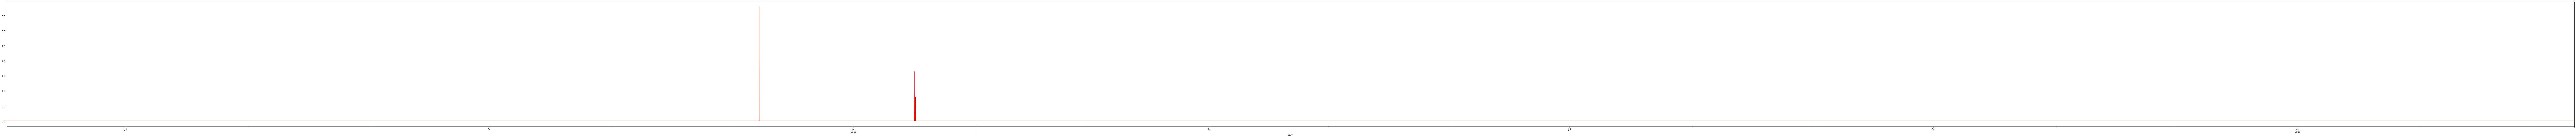

In [ ]:
plt.figure(figsize=(200,10))
df_train['snow_3h'].plot(color='red')
plt.show()

## SARIMAX

### Traffic params + snow

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, max_order=None, test='adf', m = 1, seasonal=True,
                      max_P=6, max_D= 2, max_Q=3, 
                     exogenous= train_x[['speed_avg', 'seconds_zone', 'snow_3h']],
                      maxiter=50, alpha=0.05, 
                      n_jobs=-1, 
                     information_criterion='aic', 
                      out_of_sample_size=test_size,
                      start_p=1, start_q=1, 
                      max_p=10, max_q=10, 
                      start_d=0, max_d=2,
                      trace=True, 
                      error_action='ignore', 
                      suppress_warnings=True,
                      stepwise=True
                     )

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:75: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=194504.026, Time=36.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=211175.050, Time=12.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=196377.083, Time=29.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=204267.410, Time=26.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=220335.082, Time=10.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=193018.085, Time=83.39 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=193718.098, Time=76.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=192493.126, Time=184.90 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=193780.445, Time=88.39 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=191865.005, Time=190.18 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=193630.273, Time=81.75 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=310.88 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=198.18 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=133.66 sec
 ARIMA(

In [ ]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15577
Model:               SARIMAX(4, 0, 1)   Log Likelihood              -95922.503
Date:                Mon, 26 Oct 2020   AIC                         191865.005
Time:                        05:18:45   BIC                         191941.541
Sample:                             0   HQIC                        191890.352
                              - 15577                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     51.8913      1.358     38.210      0.000      49.230      54.553
x1            -5.8617      0.165    -35.425      0.000      -6.186      -5.537
x2            -5.8252      0.951     -6.126      0.000      -7.689      -3.961
x3          -135.3680      3.401    -39.807      0.000    -142.033    -128.703
ar.L1          2.0649      0.011    196.038      0.000       2.044       2.086
ar.L2         -1.5481      0.017    -91.905      0.000      -1.581      -1.515
ar.L3          0.6338      0.015     43.147      0.000       0.605       0.663
ar.L4         -0.2178      0.008    -27.658      0.000      -0.233      -0.202
ma.L1         -0.8158      0.008    -98.257      0.000      -0.832      -0.800
sigma2      1.306e+04    127.908    102.124      0.000    1.28e+04    1.33e+04
===================================================================================
Ljung-Box (Q):                     8009.21   Jarque-Bera (JB):              1809.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Number of data points = 1440


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, Non

{'mape': 0.9285525937865774, 'me': -173.17910182734553, 'mae': 306.408872718449, 'mse': 117565.05293248211, 'rmse': 342.87760634442446}


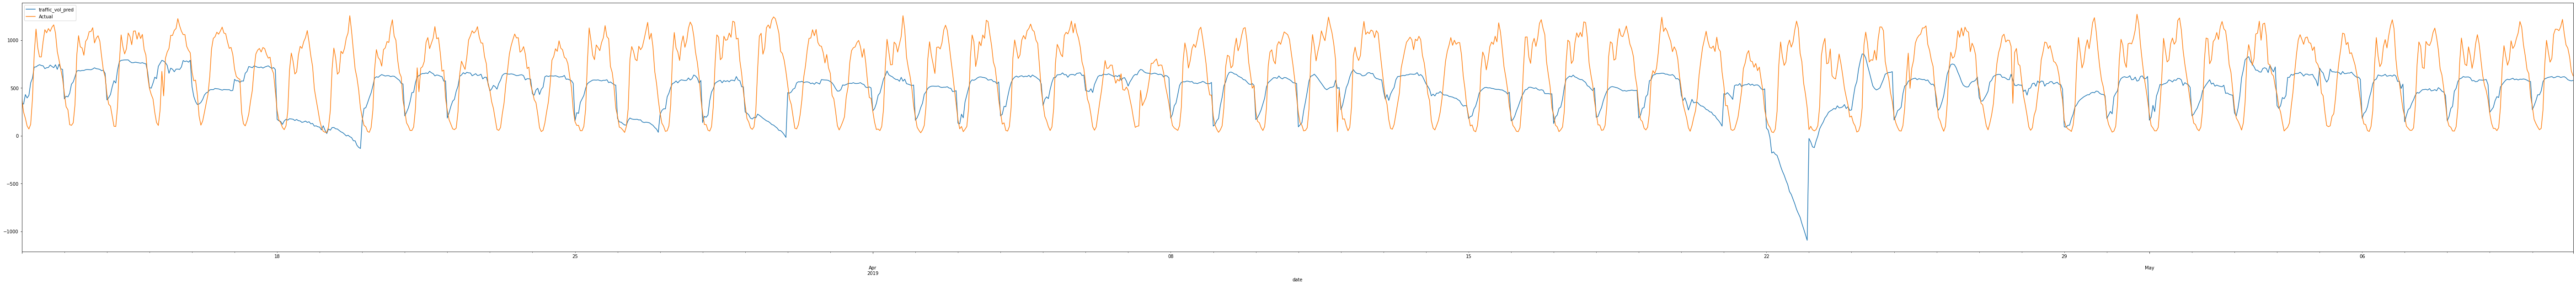

In [ ]:
rmse_list = []
mae_list = []
mape_list = []
mse_list = []

fc = []

x = PrettyTable()
x.field_names = ["Batch", "MAPE", "MSE", "MAE", "RMSE"]

num_of_days = 60
print("Number of data points =", num_of_days*24)
for train_end in range(0,(24*num_of_days),24):
  # try:
    train_set_end_index = train_size_start + train_end

    train_x = df[['speed_avg', 'seconds_zone', 'snow_3h']][:train_set_end_index]
    train_y = df['traffic_volume'][:train_set_end_index]

    test_x = df[['speed_avg', 'seconds_zone', 'snow_3h']][train_set_end_index : train_set_end_index + 24]
    test_y = df['traffic_volume'][train_set_end_index : train_set_end_index + 24]

    train_size = len(train_x)


    model= SARIMAX(train_y, exog=train_x, order=(4,0,1))
    results= model.fit()

    predictions= results.predict(start =train_size, end=train_size + 23,exog=test_x)
    fc += predictions.to_list()

    accuracy_prod = forecast_accuracy(predictions, test_y)
    
    rmse_list.append(round(accuracy_prod['rmse'],4))
    mae_list.append(round(accuracy_prod['mae'],4))
    mape_list.append(round(accuracy_prod['mape'],4))
    mse_list.append(round(accuracy_prod['mse'],4))

    x.add_row([str(train_end), round(mean(mape_list),4), round(mean(mse_list),4), round(mean(mae_list),4), round(mean(rmse_list),4)])

accuracy_prod_sarimax = forecast_accuracy(predictions, test_y)
print(accuracy_prod_sarimax)
predictions_sarima = pd.DataFrame(fc, columns = ['traffic_vol_pred'])  
predictions_sarima.index=df_test[:1440].index
predictions_sarima['Actual'] = df_test['traffic_volume'][:1440]
predictions_sarima.plot(figsize=(100,10))

### With all variables

In [ ]:
rmse_list = []
mae_list = []
mape_list = []
mse_list = []

fc = []

x = PrettyTable()
x.field_names = ["Batch", "MAPE", "MSE", "MAE", "RMSE"]

num_of_days = 60
print("Number of data points =", num_of_days*24)
for train_end in range(0,(24*num_of_days),24):
  # try:
    train_set_end_index = train_size_start + train_end

    train_x = df[['speed_avg', 'seconds_zone', 'temp', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h',
       'snow_3h', 'clouds_all']][:train_set_end_index]
    train_y = df['traffic_volume'][:train_set_end_index]

    test_x = df[['speed_avg', 'seconds_zone', 'temp', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h',
       'snow_3h', 'clouds_all']][train_set_end_index : train_set_end_index + 24]
    test_y = df['traffic_volume'][train_set_end_index : train_set_end_index + 24]

    train_size = len(train_x)


    model= SARIMAX(train_y, exog=train_x, order=(4,0,3))
    results= model.fit()

    predictions= results.predict(start =train_size, end=train_size + 23,exog=test_x)
    fc += predictions.to_list()

    accuracy_prod = forecast_accuracy(predictions, test_y)
    # print(accuracy_prod)
    
    rmse_list.append(round(accuracy_prod['rmse'],4))
    mae_list.append(round(accuracy_prod['mae'],4))
    mape_list.append(round(accuracy_prod['mape'],4))
    mse_list.append(round(accuracy_prod['mse'],4))

    x.add_row([str(train_end), round(mean(mape_list),4), round(mean(mse_list),4), round(mean(mae_list),4), round(mean(rmse_list),4)])
print(x)
    
  # except:
  #   continue

In [ ]:
accuracy_prod_sarimax = forecast_accuracy(predictions, test_y)
accuracy_prod_sarimax

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing 

{'mae': 208.14595593972743,
 'mape': 0.5150553479304759,
 'me': -148.9308809960463,
 'mse': 58018.255796972924,
 'rmse': 240.8697901293828}

In [ ]:
predictions_sarima = pd.DataFrame(fc, columns = ['traffic_vol_pred'])  
predictions_sarima.index=df_test[:1440].index
predictions_sarima['Actual'] = df_test['traffic_volume'][:1440]

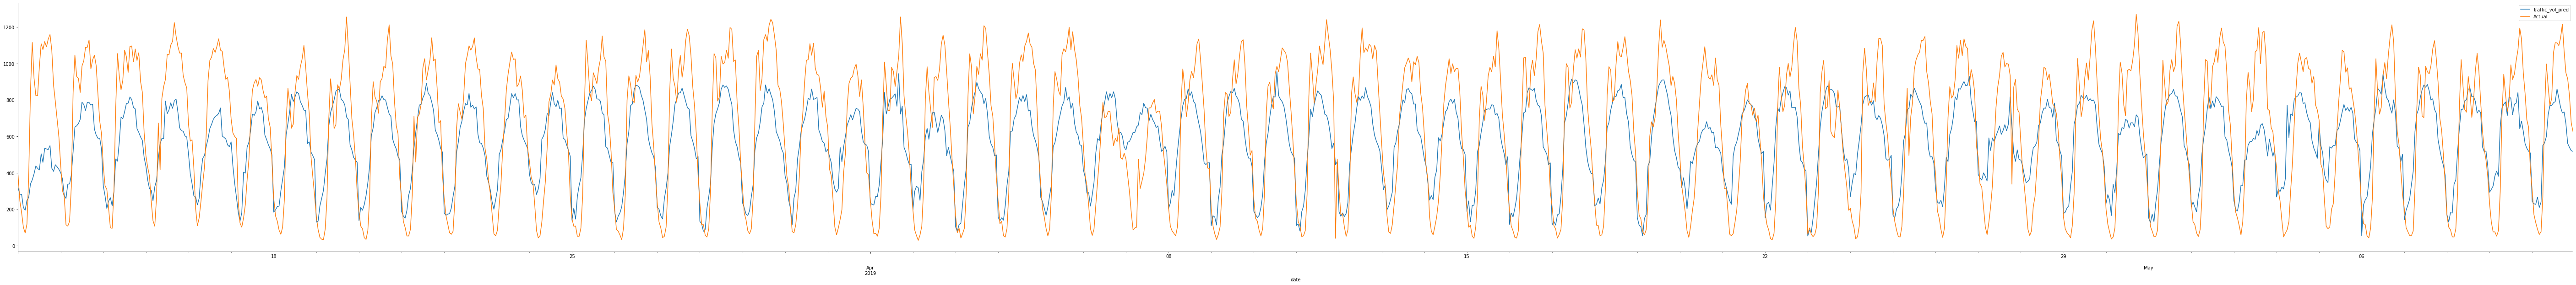

In [ ]:
predictions_sarima.plot(figsize=(100,10))

### traffic params

In [ ]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, max_order=None, test='adf', m = 1, seasonal=True,
                      max_P=6, max_D= 2, max_Q=3, 
                     exogenous= train_x[['speed_avg', 'seconds_zone']],
                      maxiter=50, alpha=0.05, 
                      n_jobs=-1, 
                     information_criterion='aic', 
                      out_of_sample_size=test_size,
                      start_p=1, start_q=1, 
                      max_p=10, max_q=10, 
                      start_d=0, max_d=2,
                      trace=True, 
                      error_action='ignore', 
                      suppress_warnings=True,
                      stepwise=True
                     )

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:75: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=212200.000, Time=48.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=230295.246, Time=10.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=214255.998, Time=37.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=222860.786, Time=25.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=240380.457, Time=8.72 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=210500.706, Time=69.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=211395.710, Time=37.38 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=209948.452, Time=95.69 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=211389.228, Time=90.86 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=96.19 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=163.87 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=209714.771, Time=163.99 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=211479.744, Time=71.96 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=209674.526, Time=174.51 sec
 AR

In [ ]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                16993
Model:               SARIMAX(2, 0, 3)   Log Likelihood             -104828.263
Date:                Mon, 26 Oct 2020   AIC                         209674.526
Time:                        06:59:30   BIC                         209744.191
Sample:                             0   HQIC                        209697.499
                              - 16993                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     51.5712      0.932     55.331      0.000      49.744      53.398
x1            -6.4508      0.165    -39.004      0.000      -6.775      -6.127
x2            -3.9842      0.947     -4.209      0.000      -5.840      -2.129
ar.L1          1.8388      0.005    381.587      0.000       1.829       1.848
ar.L2         -0.9046      0.005   -200.049      0.000      -0.913      -0.896
ma.L1         -0.6445      0.007    -87.315      0.000      -0.659      -0.630
ma.L2         -0.2545      0.008    -33.408      0.000      -0.269      -0.240
ma.L3          0.0799      0.008     10.010      0.000       0.064       0.096
sigma2      1.336e+04    125.221    106.656      0.000    1.31e+04    1.36e+04
===================================================================================
Ljung-Box (Q):                    11493.32   Jarque-Bera (JB):              1887.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Number of data points = 1440


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, Non

{'mape': 1.0252660148658024, 'me': -506.08731739892164, 'mae': 583.6859884400609, 'mse': 433873.41008465696, 'rmse': 658.6906786076884}


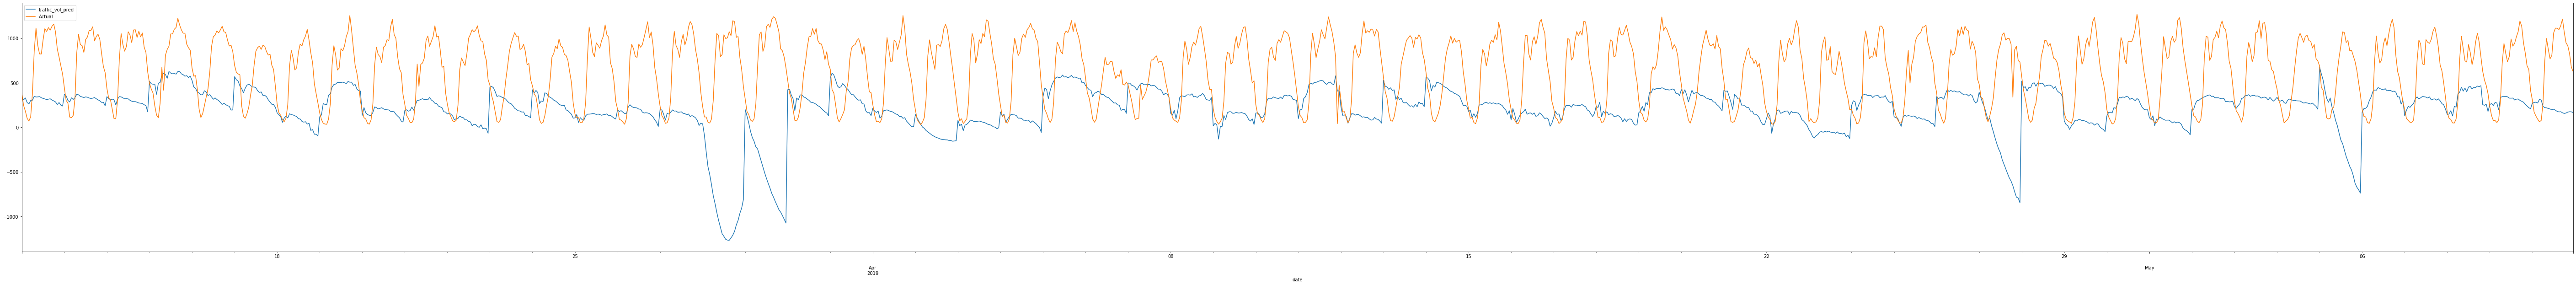

In [ ]:
rmse_list = []
mae_list = []
mape_list = []
mse_list = []

fc = []

x = PrettyTable()
x.field_names = ["Batch", "MAPE", "MSE", "MAE", "RMSE"]

num_of_days = 60
print("Number of data points =", num_of_days*24)
for train_end in range(0,(24*num_of_days),24):
  # try:
    train_set_end_index = train_size_start + train_end

    train_x = df[['speed_avg', 'seconds_zone']][:train_set_end_index]
    train_y = df['traffic_volume'][:train_set_end_index]

    test_x = df[['speed_avg', 'seconds_zone']][train_set_end_index : train_set_end_index + 24]
    test_y = df['traffic_volume'][train_set_end_index : train_set_end_index + 24]

    train_size = len(train_x)


    model= SARIMAX(train_y, exog=train_x, order=(2,0,3))
    results= model.fit()

    predictions= results.predict(start =train_size, end=train_size + 23,exog=test_x)
    fc += predictions.to_list()

    accuracy_prod = forecast_accuracy(predictions, test_y)
    
    rmse_list.append(round(accuracy_prod['rmse'],4))
    mae_list.append(round(accuracy_prod['mae'],4))
    mape_list.append(round(accuracy_prod['mape'],4))
    mse_list.append(round(accuracy_prod['mse'],4))

    x.add_row([str(train_end), round(mean(mape_list),4), round(mean(mse_list),4), round(mean(mae_list),4), round(mean(rmse_list),4)])

accuracy_prod_sarimax = forecast_accuracy(predictions, test_y)
print(accuracy_prod_sarimax)
predictions_sarima = pd.DataFrame(fc, columns = ['traffic_vol_pred'])  
predictions_sarima.index=df_test[:1440].index
predictions_sarima['Actual'] = df_test['traffic_volume'][:1440]
predictions_sarima.plot(figsize=(100,10))

## VAR

### Whole dataset

In [ ]:
model = VAR(df_train)

AIC = float('inf')
AIC_list = []
order = 0

for i in range(1, 150):
    result = model.fit(i)
    AIC_list.append(result.aic)

    if AIC > result.aic:
      AIC = result.aic
      order = i

print("Order =", order, "AIC = ", AIC)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Order = 145 AIC =  16.98021288131238


In [ ]:
for i in range(150, 200):
    result = model.fit(i)
    AIC_list.append(result.aic)

    if AIC > result.aic:
      AIC = result.aic
      order = i

print("Order =", order, "AIC = ", AIC)

Order = 183 AIC =  16.814587278934944


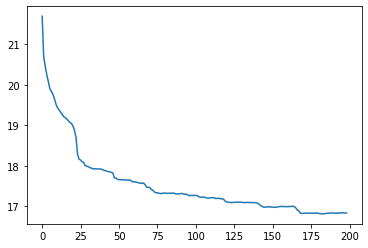

In [ ]:
import matplotlib.pyplot as plt

ys = AIC_list
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)

In [ ]:
x = PrettyTable()
x.field_names = ["Batch", "MAPE", "MSE", "MAE", "RMSE"]

rmse_var = []
mae_var = []
mape_var = []
mse_var = []

fc_var = []

lag_order = 184
num_of_days = 60
print("Number of data points =", num_of_days*24)


for train_end in range(0,(24*num_of_days),24):
  # try:
    train_set_end_index = train_size_start + train_end

    train_x = df[:train_set_end_index]
    test_x = df[train_set_end_index + lag_order : train_set_end_index + lag_order + 24]
    train_size = len(train_x)

    model = VAR(train_x)
    model_fitted_var = model.fit(lag_order)

    # Get the lag order
    lag_order = model_fitted_var.k_ar
    # print(lag_order)  #> 4
    forecast_input = df.values[train_set_end_index:train_set_end_index+lag_order]

    fc_var_temp = model_fitted_var.forecast(y=forecast_input, steps=24)
    df_forecast = pd.DataFrame(fc_var_temp, index=df.index[-24:], columns=df.columns)


    fc_var += df_forecast['traffic_volume'].to_list()
    accuracy_prod = forecast_accuracy(df_forecast['traffic_volume'].values, test_x['traffic_volume'].values)
    
    rmse_var.append(round(accuracy_prod['rmse'],4))
    mae_var.append(round(accuracy_prod['mae'],4))
    mape_var.append(round(accuracy_prod['mape'],4))
    mse_var.append(round(accuracy_prod['mse'],4))

    x.add_row([str(train_end), round(mean(mape_var),4), round(mean(mse_var),4), round(mean(mae_var),4), round(mean(rmse_var),4)])
print(x)
    
  # except:
  #   continue

Number of data points = 1440


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa

+-------+--------+------------+---------+----------+
| Batch |  MAPE  |    MSE     |   MAE   |   RMSE   |
+-------+--------+------------+---------+----------+
|   0   | 0.301  | 7262.9968  |  74.019 | 85.2232  |
|   24  | 0.3128 | 13330.7514 | 89.0148 | 112.2509 |
|   48  | 0.2858 | 12893.2853 | 87.0188 | 111.3766 |
|   72  | 0.2572 | 11640.3504 | 84.1094 | 105.727  |
|   96  | 0.2593 | 10982.4123 | 82.0657 | 102.858  |
|  120  | 0.296  | 12062.4537 | 86.5762 | 107.7394 |
|  144  | 0.2831 | 10917.292  |  81.775 | 101.4353 |
|  168  | 0.2723 | 10618.1564 | 79.5539 | 100.2967 |
|  192  | 0.2557 | 10013.4968 | 76.4213 | 97.1466  |
|  216  | 0.242  | 9692.2968  | 75.4402 | 95.6791  |
|  240  | 0.2308 | 9162.6454  | 72.9051 | 92.6335  |
|  264  | 0.2345 | 9091.9429  | 73.0111 | 92.5126  |
|  288  | 0.2424 | 9188.1494  | 74.2285 | 93.2192  |
|  312  | 0.2375 | 8889.3827  | 72.7912 | 91.6142  |
|  336  | 0.237  | 8768.6829  | 72.2223 | 91.1157  |
|  360  |  0.23  | 8485.7515  | 70.7392 | 89.4

In [ ]:
accuracy_prod_var = forecast_accuracy(df_forecast['traffic_volume'].values, test_x['traffic_volume'].values)

In [ ]:
accuracy_prod_var

{'mae': 46.3753460544411,
 'mape': 0.1252224733502437,
 'me': 15.61728496956564,
 'mse': 3682.1440745274426,
 'rmse': 60.68067299006697}

In [ ]:
points = 24*num_of_days
predictions_var = pd.DataFrame(fc_var, columns = ['traffic_vol_pred'])
predictions_var.index=df_test[lag_order:points+lag_order].index
predictions_var['Actual'] = df_test['traffic_volume'][lag_order:points+lag_order]

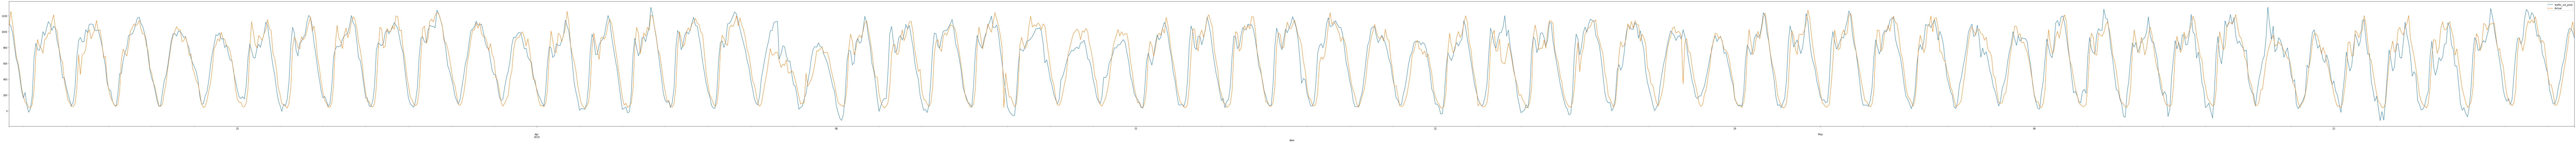

In [ ]:
predictions_var.plot(figsize=(200,10), legend=True)

### speed,time,snow,volume

In [ ]:
model = VAR(df_train[['speed_avg', 'seconds_zone', 'snow_3h', 'traffic_volume']])

AIC = float('inf')
AIC_list = []
order = 0

for i in range(1, 150):
    result = model.fit(i)
    AIC_list.append(result.aic)

    if AIC > result.aic:
      AIC = result.aic
      order = i

print("Order =", order, "AIC = ", AIC)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Order = 146 AIC =  2.4325530720879085


In [ ]:
for i in range(150, 200):
    result = model.fit(i)
    AIC_list.append(result.aic)

    if AIC > result.aic:
      AIC = result.aic
      order = i

print("Order =", order, "AIC = ", AIC)

Order = 171 AIC =  2.2530862418071367


In [ ]:
for i in range(200, 250):
    result = model.fit(i)
    AIC_list.append(result.aic)

    if AIC > result.aic:
      AIC = result.aic
      order = i

print("Order =", order, "AIC = ", AIC)

Order = 171 AIC =  2.2530862418071367


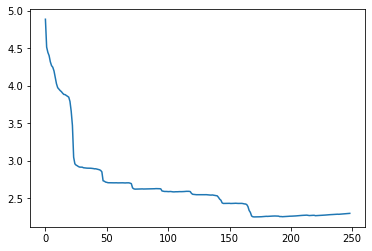

In [ ]:
import matplotlib.pyplot as plt

ys = AIC_list
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)

In [ ]:
x = PrettyTable()
x.field_names = ["Batch", "MAPE", "MSE", "MAE", "RMSE"]

rmse_var = []
mae_var = []
mape_var = []
mse_var = []

fc_var = []

lag_order = 172

num_of_days = 60
print("Number of data points =", num_of_days*24)


for train_end in range(0,(24*num_of_days),24):
  # try:
    train_set_end_index = train_size_start + train_end

    train_x = df[['speed_avg', 'seconds_zone', 'snow_3h', 'traffic_volume']][:train_set_end_index]
    test_x = df[['speed_avg', 'seconds_zone', 'snow_3h', 'traffic_volume']][train_set_end_index + lag_order : train_set_end_index + lag_order + 24]
    train_size = len(train_x)

    model = VAR(train_x)
    model_fitted_var = model.fit(lag_order)

    # Get the lag order
    lag_order = model_fitted_var.k_ar
    # print(lag_order)  #> 4
    forecast_input = df[['speed_avg', 'seconds_zone', 'snow_3h', 'traffic_volume']].values[train_set_end_index:train_set_end_index+lag_order]

    fc_var_temp = model_fitted_var.forecast(y=forecast_input, steps=24)
    df_forecast = pd.DataFrame(fc_var_temp, index=df.index[-24:], columns=df[['speed_avg', 'seconds_zone', 'snow_3h', 'traffic_volume']].columns)


    fc_var += df_forecast['traffic_volume'].to_list()
    accuracy_prod = forecast_accuracy(df_forecast['traffic_volume'].values, test_x['traffic_volume'].values)
    
    rmse_var.append(round(accuracy_prod['rmse'],4))
    mae_var.append(round(accuracy_prod['mae'],4))
    mape_var.append(round(accuracy_prod['mape'],4))
    mse_var.append(round(accuracy_prod['mse'],4))

    x.add_row([str(train_end), round(mean(mape_var),4), round(mean(mse_var),4), round(mean(mae_var),4), round(mean(rmse_var),4)])
#print(x)
    
  # except:
  #   continue

Number of data points = 1440


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa

In [ ]:
accuracy_prod_var = forecast_accuracy(df_forecast['traffic_volume'].values, test_x['traffic_volume'].values)
accuracy_prod_var

{'mae': 41.918309869847484,
 'mape': 0.08540540780575716,
 'me': -16.12820875802312,
 'mse': 2733.496037852576,
 'rmse': 52.28284649722676}

In [ ]:
points = 24*num_of_days
predictions_var = pd.DataFrame(fc_var, columns = ['traffic_vol_pred'])
predictions_var.index=df_test[lag_order:points+lag_order].index
predictions_var['Actual'] = df_test['traffic_volume'][lag_order:points+lag_order]

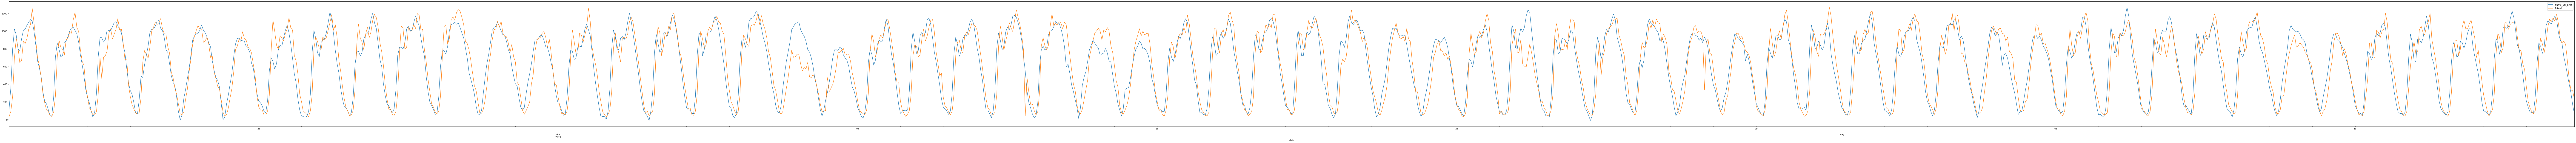

In [ ]:
predictions_var.plot(figsize=(200,10))

In [ ]:
predictions_var

traffic_vol_pred  Actual
date                                         
2019-03-19 04:00:00        113.864203    34.0
2019-03-19 05:00:00        364.174576    92.0
2019-03-19 06:00:00        799.949541   262.0
2019-03-19 07:00:00       1022.455920   697.0
2019-03-19 08:00:00        957.317338   916.0
...                               ...     ...
2019-05-17 23:00:00        506.726029   666.0
2019-05-18 00:00:00        402.627981   454.0
2019-05-18 01:00:00        301.204428   334.0
2019-05-18 02:00:00        163.334297   325.0
2019-05-18 03:00:00         56.691590   221.0

[1440 rows x 2 columns]

In [ ]:
predictions_var.to_csv('/content/drive/My Drive/FYP/predictions_var.csv')

In [ ]:
model = VAR(df[['speed_avg', 'seconds_zone', 'snow_3h', 'traffic_volume']]['2017-06-01 00:00:00':'2019-03-12 00:00:00'])
model_fitted_var = model.fit(172)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
model_fitted_var.aic

2.253714524570023

In [ ]:
model_fitted_var.save('/content/drive/My Drive/FYP/VAR_traffic_snow_final.pkl')

### Speed,time,vol

In [ ]:
model = VAR(df_train[['speed_avg', 'seconds_zone', 'traffic_volume']])

AIC = float('inf')
AIC_list = []
order = 0

for i in range(1, 150):
    result = model.fit(i)
    AIC_list.append(result.aic)

    if AIC > result.aic:
      AIC = result.aic
      order = i

print("Order =", order, "AIC = ", AIC)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Order = 149 AIC =  9.130841328984188


In [ ]:
for i in range(150, 200):
    result = model.fit(i)
    AIC_list.append(result.aic)

    if AIC > result.aic:
      AIC = result.aic
      order = i

print("Order =", order, "AIC = ", AIC)

Order = 195 AIC =  8.926026755301605


In [ ]:
for i in range(200, 250):
    result = model.fit(i)
    AIC_list.append(result.aic)

    if AIC > result.aic:
      AIC = result.aic
      order = i

print("Order =", order, "AIC = ", AIC)

Order = 195 AIC =  8.926026755301605


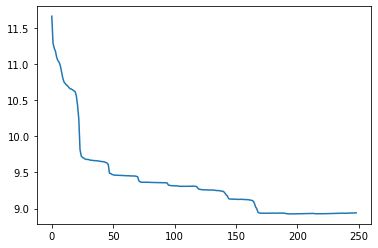

In [ ]:
import matplotlib.pyplot as plt

ys = AIC_list
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)

In [ ]:
x = PrettyTable()
x.field_names = ["Batch", "MAPE", "MSE", "MAE", "RMSE"]

rmse_var = []
mae_var = []
mape_var = []
mse_var = []

fc_var = []

lag_order = order + 1

num_of_days = 60
print("Number of data points =", num_of_days*24)


for train_end in range(0,(24*num_of_days),24):
  # try:
    train_set_end_index = train_size_start + train_end

    train_x = df[['speed_avg', 'seconds_zone', 'traffic_volume']][:train_set_end_index]
    test_x = df[['speed_avg', 'seconds_zone', 'traffic_volume']][train_set_end_index + lag_order : train_set_end_index + lag_order + 24]
    train_size = len(train_x)

    model = VAR(train_x)
    model_fitted_var = model.fit(lag_order)

    # Get the lag order
    lag_order = model_fitted_var.k_ar
    # print(lag_order)  #> 4
    forecast_input = df[['speed_avg', 'seconds_zone', 'traffic_volume']].values[train_set_end_index:train_set_end_index+lag_order]

    fc_var_temp = model_fitted_var.forecast(y=forecast_input, steps=24)
    df_forecast = pd.DataFrame(fc_var_temp, index=df.index[-24:], columns=df[['speed_avg', 'seconds_zone', 'traffic_volume']].columns)


    fc_var += df_forecast['traffic_volume'].to_list()
    accuracy_prod = forecast_accuracy(df_forecast['traffic_volume'].values, test_x['traffic_volume'].values)
    
    rmse_var.append(round(accuracy_prod['rmse'],4))
    mae_var.append(round(accuracy_prod['mae'],4))
    mape_var.append(round(accuracy_prod['mape'],4))
    mse_var.append(round(accuracy_prod['mse'],4))

    x.add_row([str(train_end), round(mean(mape_var),4), round(mean(mse_var),4), round(mean(mae_var),4), round(mean(rmse_var),4)])
# print(x)
    
  # except:
  #   continue

Number of data points = 1440


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa

In [ ]:
accuracy_prod_var = forecast_accuracy(df_forecast['traffic_volume'].values, test_x['traffic_volume'].values)
accuracy_prod_var

{'mae': 42.63417246493834,
 'mape': 0.12295888299973977,
 'me': -5.865780506810553,
 'mse': 3016.51471173016,
 'rmse': 54.92280684497251}

In [ ]:
points = 24*num_of_days
predictions_var = pd.DataFrame(fc_var, columns = ['traffic_vol_pred'])
predictions_var.index=df_test[lag_order:points+lag_order].index
predictions_var['Actual'] = df_test['traffic_volume'][lag_order:points+lag_order]

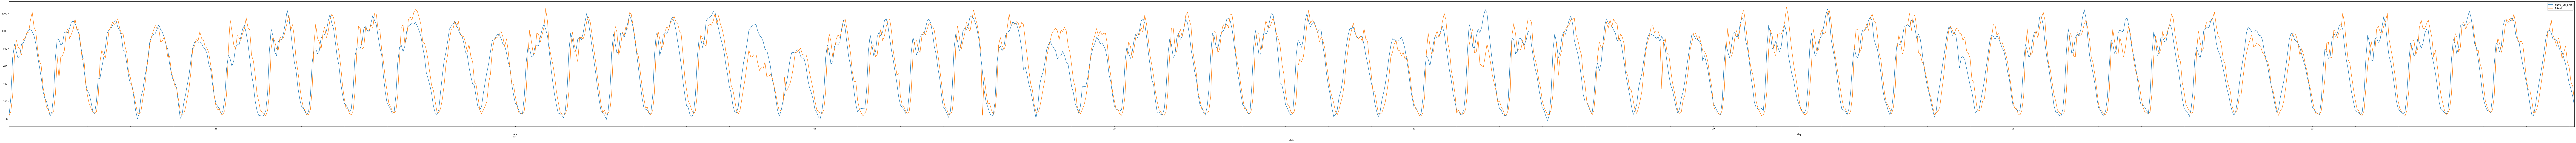

In [ ]:
predictions_var.plot(figsize=(200,10))

## ARIMA

In [ ]:
rmse_arima = []
mae_arima = []
mape_arima = []
mse_arima = []

fc_arima = []

x = PrettyTable()
x.field_names = ["Batch", "MAPE", "MSE", "MAE", "RMSE"]

num_of_days = 60
print("Number of data points =", num_of_days*24)
for train_end in range(0,(24*num_of_days),24):
  # try:
    train_set_end_index = train_size_start + train_end

    train_y = df['traffic_volume'][:train_set_end_index]
    test_y = df['traffic_volume'][train_set_end_index : train_set_end_index + 24]

    train_size = len(train_y)


    model = ARIMA(train_y, order=(24,0,10))
    model_fit = model.fit(disp=0)

    fc, se, conf = model_fit.forecast(24, alpha=0.05)  # 95% conf
    predictions= model_fit.predict(start =train_size, end=train_size+24)
    fc_arima += predictions.to_list()

    accuracy_prod = forecast_accuracy(fc, test_y)
    # print(accuracy_prod)
    
    rmse_list.append(round(accuracy_prod['mse'],4))
    mae_list.append(round(accuracy_prod['mae'],4))
    mape_list.append(round(accuracy_prod['mape'],4))
    mse_list.append(round(accuracy_prod['mse'],4))

    x.add_row([str(train_end), round(mean(mape_list),4), round(mean(mse_list),4), round(mean(mae_list),4), round(mean(rmse_list),4)])
    print(x)
    
  # except:
  #   continue

Number of data points = 1440


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+----------+
| Batch |  MAPE  |    MSE     |   MAE    |   RMSE   |
+-------+--------+------------+----------+----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 | 380.1412 |
+-------+--------+------------+----------+----------+
+-------+--------+------------+----------+----------+
| Batch |  MAPE  |    MSE     |   MAE    |   RMSE   |
+-------+--------+------------+----------+----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 | 380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 | 481.2893 |
+-------+--------+------------+----------+----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+----------+
| Batch |  MAPE  |    MSE     |   MAE    |   RMSE   |
+-------+--------+------------+----------+----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 | 380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 | 481.2893 |
|   48  | 0.588  | 49584.0731 | 182.6249 | 628.1948 |
+-------+--------+------------+----------+----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+----------+
| Batch |  MAPE  |    MSE     |   MAE    |   RMSE   |
+-------+--------+------------+----------+----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 | 380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 | 481.2893 |
|   48  | 0.588  | 49584.0731 | 182.6249 | 628.1948 |
|   72  | 0.5812 | 49134.9962 | 181.4592 | 944.0535 |
+-------+--------+------------+----------+----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+-----------+
| Batch |  MAPE  |    MSE     |   MAE    |    RMSE   |
+-------+--------+------------+----------+-----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 |  380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 |  481.2893 |
|   48  | 0.588  | 49584.0731 | 182.6249 |  628.1948 |
|   72  | 0.5812 | 49134.9962 | 181.4592 |  944.0535 |
|   96  | 0.5751 | 48528.4033 | 179.8869 | 1078.8597 |
+-------+--------+------------+----------+-----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+-----------+
| Batch |  MAPE  |    MSE     |   MAE    |    RMSE   |
+-------+--------+------------+----------+-----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 |  380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 |  481.2893 |
|   48  | 0.588  | 49584.0731 | 182.6249 |  628.1948 |
|   72  | 0.5812 | 49134.9962 | 181.4592 |  944.0535 |
|   96  | 0.5751 | 48528.4033 | 179.8869 | 1078.8597 |
|  120  | 0.5703 | 48153.4443 | 179.0037 | 1422.8332 |
+-------+--------+------------+----------+-----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+-----------+
| Batch |  MAPE  |    MSE     |   MAE    |    RMSE   |
+-------+--------+------------+----------+-----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 |  380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 |  481.2893 |
|   48  | 0.588  | 49584.0731 | 182.6249 |  628.1948 |
|   72  | 0.5812 | 49134.9962 | 181.4592 |  944.0535 |
|   96  | 0.5751 | 48528.4033 | 179.8869 | 1078.8597 |
|  120  | 0.5703 | 48153.4443 | 179.0037 | 1422.8332 |
|  144  | 0.5701 | 48159.9316 | 178.7697 | 2126.7923 |
+-------+--------+------------+----------+-----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+-----------+
| Batch |  MAPE  |    MSE     |   MAE    |    RMSE   |
+-------+--------+------------+----------+-----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 |  380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 |  481.2893 |
|   48  | 0.588  | 49584.0731 | 182.6249 |  628.1948 |
|   72  | 0.5812 | 49134.9962 | 181.4592 |  944.0535 |
|   96  | 0.5751 | 48528.4033 | 179.8869 | 1078.8597 |
|  120  | 0.5703 | 48153.4443 | 179.0037 | 1422.8332 |
|  144  | 0.5701 | 48159.9316 | 178.7697 | 2126.7923 |
|  168  | 0.5676 | 47545.8744 | 177.1184 |  2189.693 |
+-------+--------+------------+----------+-----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+-----------+
| Batch |  MAPE  |    MSE     |   MAE    |    RMSE   |
+-------+--------+------------+----------+-----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 |  380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 |  481.2893 |
|   48  | 0.588  | 49584.0731 | 182.6249 |  628.1948 |
|   72  | 0.5812 | 49134.9962 | 181.4592 |  944.0535 |
|   96  | 0.5751 | 48528.4033 | 179.8869 | 1078.8597 |
|  120  | 0.5703 | 48153.4443 | 179.0037 | 1422.8332 |
|  144  | 0.5701 | 48159.9316 | 178.7697 | 2126.7923 |
|  168  | 0.5676 | 47545.8744 | 177.1184 |  2189.693 |
|  192  | 0.5625 | 46910.6814 | 175.2877 |  2211.836 |
+-------+--------+------------+----------+-----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+-----------+
| Batch |  MAPE  |    MSE     |   MAE    |    RMSE   |
+-------+--------+------------+----------+-----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 |  380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 |  481.2893 |
|   48  | 0.588  | 49584.0731 | 182.6249 |  628.1948 |
|   72  | 0.5812 | 49134.9962 | 181.4592 |  944.0535 |
|   96  | 0.5751 | 48528.4033 | 179.8869 | 1078.8597 |
|  120  | 0.5703 | 48153.4443 | 179.0037 | 1422.8332 |
|  144  | 0.5701 | 48159.9316 | 178.7697 | 2126.7923 |
|  168  | 0.5676 | 47545.8744 | 177.1184 |  2189.693 |
|  192  | 0.5625 | 46910.6814 | 175.2877 |  2211.836 |
|  216  | 0.5571 | 46348.0882 | 173.6329 | 2287.7978 |
+-------+--------+------------+----------+-----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


+-------+--------+------------+----------+-----------+
| Batch |  MAPE  |    MSE     |   MAE    |    RMSE   |
+-------+--------+------------+----------+-----------+
|   0   | 0.6029 | 50941.1303 | 186.0714 |  380.1412 |
|   24  | 0.595  | 50226.7786 | 184.1829 |  481.2893 |
|   48  | 0.588  | 49584.0731 | 182.6249 |  628.1948 |
|   72  | 0.5812 | 49134.9962 | 181.4592 |  944.0535 |
|   96  | 0.5751 | 48528.4033 | 179.8869 | 1078.8597 |
|  120  | 0.5703 | 48153.4443 | 179.0037 | 1422.8332 |
|  144  | 0.5701 | 48159.9316 | 178.7697 | 2126.7923 |
|  168  | 0.5676 | 47545.8744 | 177.1184 |  2189.693 |
|  192  | 0.5625 | 46910.6814 | 175.2877 |  2211.836 |
|  216  | 0.5571 | 46348.0882 | 173.6329 | 2287.7978 |
|  240  | 0.5517 | 45827.6568 | 172.2819 | 2387.9338 |
+-------+--------+------------+----------+-----------+


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


KeyboardInterrupt: ignored

In [ ]:
predictions_arima = pd.DataFrame(fc_arima, columns = ['traffic_vol_pred'])  
predictions_arima.index=df_test[:1600].index
predictions_arima['Actual'] = df_test['traffic_volume'][:1600]

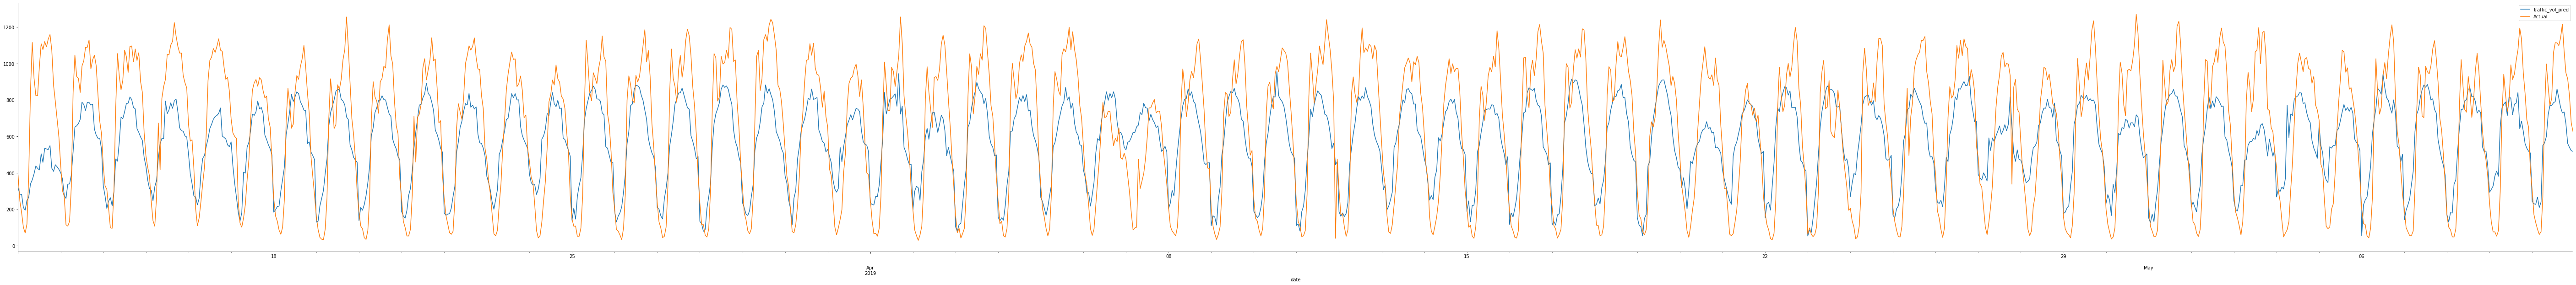

In [ ]:
predictions_sarima.plot(figsize=(100,10))